# Simple Congestion Simulation

This notebook simulates low-voltage demand on a synthetic grid and estimates congestion risk.

In [1]:
%matplotlib inline
import pandas as pd
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from src.grid_model import generate_lv_grid, plot_lv_grid
from src.simulate import generate_hourly_load_profiles_realistic, save_load_profiles
from src.visualize import compute_total_load, plot_total_load, plot_all_houses

## Parameters

The grid consists of N_HOUSES connected to a transformer with TRANSFORMER_CAPACITY. Each house has its own load profile spread over HOURS hours per day.

In [2]:
# Parameters
N_HOUSES = 50
HOURS = 24
TRANSFORMER_CAPACITY = 110  # kW
TRANSFORMER_ID = "TR_001"
DATA_DIR = "../data/generated"
PLOTS_DIR = "../data/plots"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

## Generate Synthetic Grid

Create a low-voltage grid model with houses:

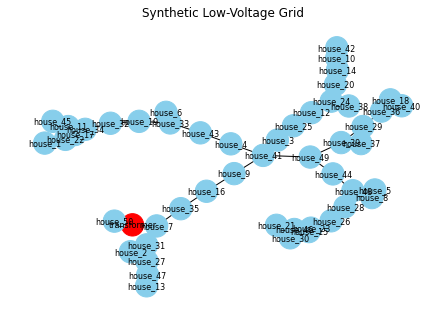

In [3]:
G = generate_lv_grid(N_HOUSES)
# Plot synthetic grid
plot_lv_grid(G, plot_name=f"{PLOTS_DIR}/01_simple_simulation_grid_model.png")

## Generate Load Profiles

Create realistic hourly load profiles for each house. Profiles are approximated by the sum of four components:
- base load (constant)
- morning peak (Gaussian)
- midday peak (Gaussian)
- evening peak (Gaussian multiplied by one-side exponential with tail wrapped around midnight)

Parameters for components are picked from uniform distributions within plausible ranges.

In [4]:
house_ids = list(G.nodes())
load_profiles = generate_hourly_load_profiles_realistic(house_ids)

# Save profiles with transformer ID
saved_path = save_load_profiles(
    load_profiles,
    output_path=DATA_DIR,
    prefix="house",
    start_id=1,
    transformer_id=TRANSFORMER_ID,
)

Saved load profiles to ../data/generated/load_profiles_TR_001.csv


## Load and Prepare Data for Visualization

Removing transformer (idle load only).

In [5]:
loaded_profiles = pd.read_csv(saved_path, index_col="house_id")
print(f"Loaded profiles shape: {loaded_profiles.shape}")

viz_profiles = loaded_profiles.loc[
    ~loaded_profiles.index.str.startswith("transformer"), :
]
viz_profiles = viz_profiles.drop(columns=["transformer_id"])
print(f"Houses profiles shape: {viz_profiles.shape}")

Loaded profiles shape: (51, 25)
Houses profiles shape: (50, 24)


## Visualize Results

### Plot load profiles of all Houses

For fun, a simple [Joy Division - style](https://www.radiox.co.uk/artists/joy-division/cover-joy-division-unknown-pleasures-meaning/) visualization of all house load profiles:

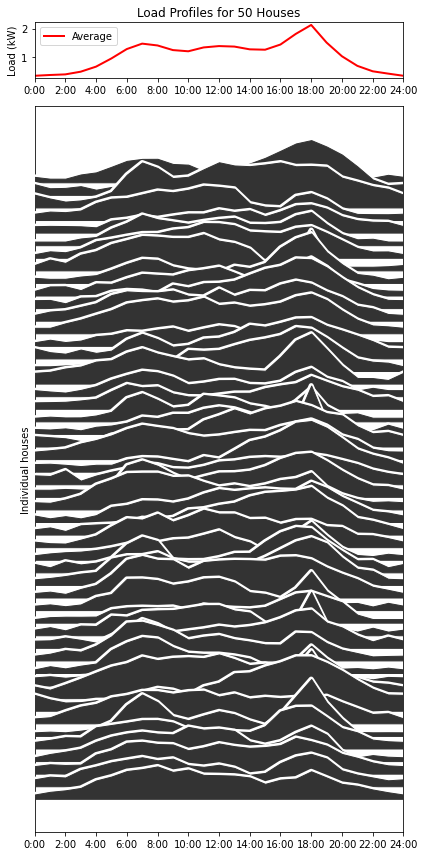

In [6]:
plot_all_houses(
    viz_profiles, plot_name=f"{PLOTS_DIR}/02_simple_simulation_all_houses.png"
)

### Plot Total Load
Visualize total load against transformer capacity to identify congestion risk:

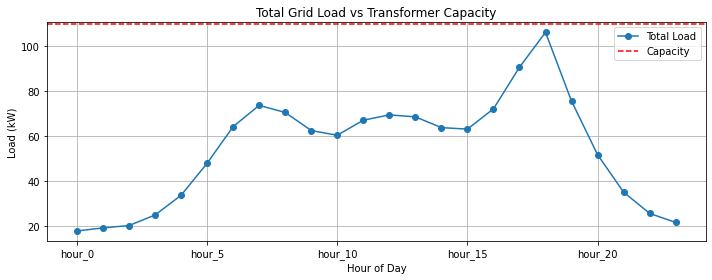

In [7]:
total = compute_total_load(viz_profiles)
plot_total_load(
    total,
    transformer_capacity=TRANSFORMER_CAPACITY,
    plot_name=f"{PLOTS_DIR}/03_simple_simulation_total_load.png",
)